In [157]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

NOTION_TOKEN = "secret_AIc5tovrF5rnoYWC54z9CzwQUNb5d2A1q3HPKwOEqup"
DATABASE_ID = "213b4ff8bb884cfc987139ae53aa4396"

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

401
401
401
401
401
401
401
401
401
401


In [158]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [159]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

In [160]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2) 

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [161]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [162]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [163]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

In [164]:
matrixs[0]

,이현식,조윤남,나재철,이정훈,송혁,하창룡,이동훈,박동현,홍대한,박찬수,...,이어룡,양홍석,김봉규,조경순,김병철,김창봉,박찬욱,배영훈,이인형,장우철
이현식,49.0,17.6,17.79,13.76,24.15,23.64,16.75,24.15,21.62,14.36,...,12.88,20.87,24.71,21.73,22.39,12.06,15.36,26.64,10.64,23.85
조윤남,17.6,49.0,12.33,8.72,17.98,20.43,21.31,20.32,20.92,9.75,...,10.13,11.57,19.58,20.75,20.25,8.72,8.72,20.09,10.58,25.14
나재철,17.79,12.33,49.0,8.6,13.94,13.33,11.37,13.28,16.27,10.97,...,20.11,21.4,15.19,16.21,15.72,10.82,11.85,18.22,9.48,15.54
이정훈,13.76,8.72,8.6,49.0,11.81,11.31,8.23,15.13,10.14,26.8,...,11.63,10.32,9.99,10.19,10.11,23.86,34.13,9.74,21.85,9.18
송혁,24.15,17.98,13.94,11.81,49.0,20.2,16.8,19.73,20.65,12.37,...,11.42,14.13,19.95,21.28,21.2,10.24,13.3,21.77,10.24,20.19
하창룡,23.64,20.43,13.33,11.31,20.2,49.0,19.33,30.7,22.92,14.7,...,12.52,11.57,26.21,23.21,18.18,12.37,11.31,19.01,9.04,21.59
이동훈,16.75,21.31,11.37,8.23,16.8,19.33,49.0,19.31,22.1,9.23,...,10.14,10.19,16.77,22.09,16.82,8.23,8.23,18.28,9.48,20.62
박동현,24.15,20.32,13.28,15.13,19.73,30.7,19.31,49.0,22.68,17.22,...,12.52,11.57,25.81,22.87,17.99,12.48,11.43,18.98,9.14,23.06
홍대한,21.62,20.92,16.27,10.14,20.65,22.92,22.1,22.68,49.0,12.71,...,11.5,14.13,20.03,30.94,19.66,12.54,11.52,21.01,13.19,22.62
박찬수,14.36,9.75,10.97,26.8,12.37,14.7,9.23,17.22,12.71,49.0,...,12.82,9.5,14.75,14.99,9.86,25.3,29.02,12.26,20.43,11.62


### 중요인물선정

In [165]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
이어룡: 7
홍대한: 6
송혁: 6
이순남: 5
김상원: 5
오익근: 5
김범철: 5
신인식: 4
조경순: 4
박성준: 4
정연규: 4
진승욱: 4
김성원: 4
권택현: 4
김호중: 4
이정화: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
나재철: 3
박동현: 3
이동훈: 3
김병철: 3
정재중: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
김재중: 2
최명재: 2
배영훈: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
정태암: 1
이환목: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [166]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [167]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '이어룡', '홍대한', '송혁', '이순남', '김상원', '오익근', '김범철', '신인식', '조경순', '박성준', '정연규', '진승욱', '김성원', '권택현', '김호중', '이정화', '이재우', '박현식', '나유석', '신재범', '홍종국', '나재철', '박동현', '이동훈', '김병철', '정재중', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '김재중', '최명재', '배영훈', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


### 네트워크 시각화

In [168]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def print_network(matrixs):
    for k in range(len(matrixs)):
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 90)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'Malgun Gothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='Malgun Gothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
    
        # 노드와 중요인물과의 연결 개수를 포함하는 딕셔너리 생성
        node_connections = {n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p) for n in sorted_nodes}

        # 딕셔너리 출력
        # for node, connections in node_connections.items():
        #     print(f"{node}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)
        
        def normalize_centrality(centrality_dict):        # 중심성들 0 ~ 1 값으로 정규화
            max_value = max(centrality_dict.values())
            min_value = min(centrality_dict.values())
            normalized_centrality = {node: (value - min_value) / (max_value - min_value) for node, value in centrality_dict.items()}
            return normalized_centrality

        normalized_node_connections = normalize_centrality(node_connections)
        normalized_degree_centrality = normalize_centrality(degree_centrality)
        normalized_betweenness_centrality = normalize_centrality(betweenness_centrality)
        normalized_closeness_centrality = normalize_centrality(closeness_centrality)
        normalized_eigenvector_centrality = normalize_centrality(eigenvector_centrality)
                
        # 딕셔너리 키 순서를 정렬하기 위한 공통 키 리스트 생성
        common_keys = sorted(node_connections.keys())

        result_dict = {}
        for node in common_keys:
            result_dict[node] = [normalized_node_connections[node], normalized_degree_centrality[node], normalized_betweenness_centrality[node], normalized_closeness_centrality[node], normalized_eigenvector_centrality[node]]

        # for node, values in result_dict.items():
        #     print(f"{node}: {values}")
        
        def weighted_average_values(result_dict, weights):
            # 각 키에 해당하는 값들을 가중 평균하여 하나의 값으로 계산
            weighted_values = []
            for values in result_dict.values():
                weighted_value = sum(value * weight for value, weight in zip(values, weights))
                weighted_values.append(weighted_value)
            
            # result_dict 업데이트
            keys = list(result_dict.keys())
            for i, key in enumerate(keys):
                result_dict[key] = weighted_values[i]
            
            return result_dict
        
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]        # 속성별 가중치 값
        result_dict = weighted_average_values(result_dict, weights)  
        
        for key in result_dict:
            result_dict[key] *= 100
    
        # # 결과 출력
        # print("{0}년도 네트워크 점수 계산".format(2014+k))
        # print()
        # print("중요인물 연결 수")
        # for node, centrality in sorted(node_connections.items(), key=lambda x: x[1], reverse=True):
        #     print(node, centrality)
        # print()
        # print("Degree Centrality:")
        # for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
        #     print(node, centrality)
        # print()
        # print("Betweenness Centrality:")
        # for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
        #     print(node, centrality)
        # print()
        # print("Closeness Centrality:")
        # for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
        #     print(node, centrality)
        # print()
        # print("Eigenvector Centrality:")
        # for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
        #     print(node, centrality)
        # print()
        print('==최종 핵심 인물 점수==')
        for node, centrality in sorted(result_dict.items(), key=lambda x: x[1], reverse=True):
            print(f'{node}: {centrality}')

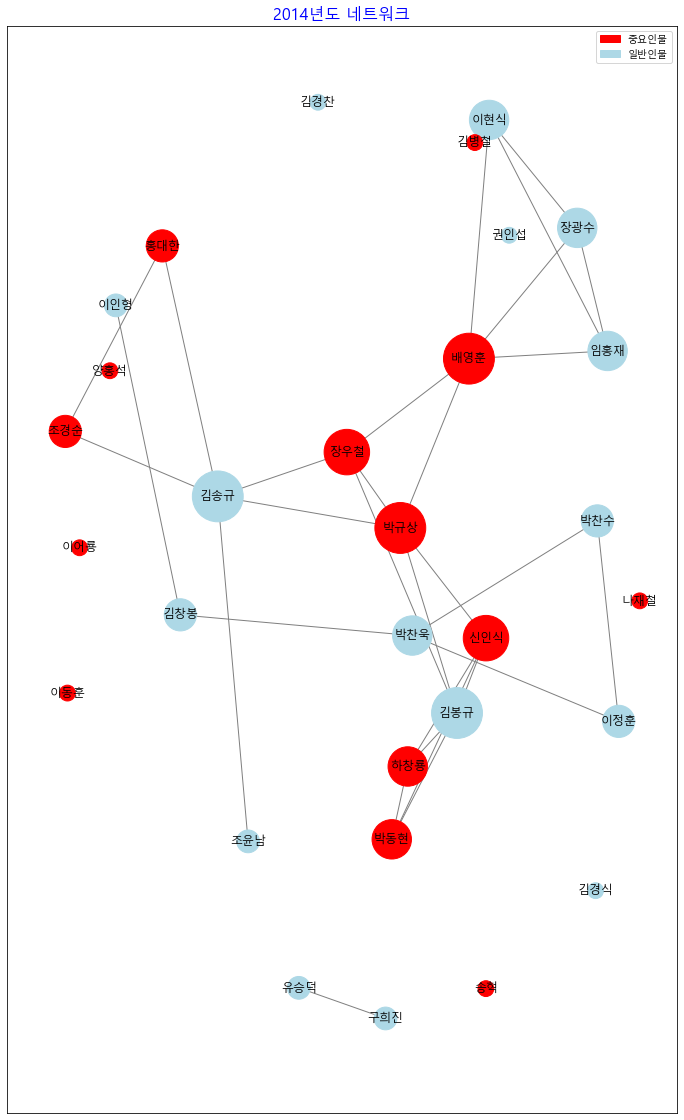

==최종 핵심 인물 점수==
박규상: 91.47916666666667
김송규: 84.27595042224151
김봉규: 83.71192556899288
배영훈: 78.02067577106178
장우철: 70.71658884191888
신인식: 62.87674717427668
박동현: 43.23961603448168
하창룡: 43.23961603448168
이현식: 35.36955762024195
임홍재: 35.36955762024195
장광수: 35.36955762024195
조경순: 27.443077299344644
홍대한: 27.443077299344644
박찬욱: 22.45266349594401
조윤남: 18.11176834489562
김창봉: 16.502219374035583
박찬수: 13.680474010216571
이정훈: 13.680474010216571
이인형: 8.418146154918666
구희진: 6.4852071005917225
유승덕: 6.4852071005917225
권인섭: 0.0
김경식: 0.0
김경찬: 0.0
김병철: 0.0
나재철: 0.0
송혁: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0


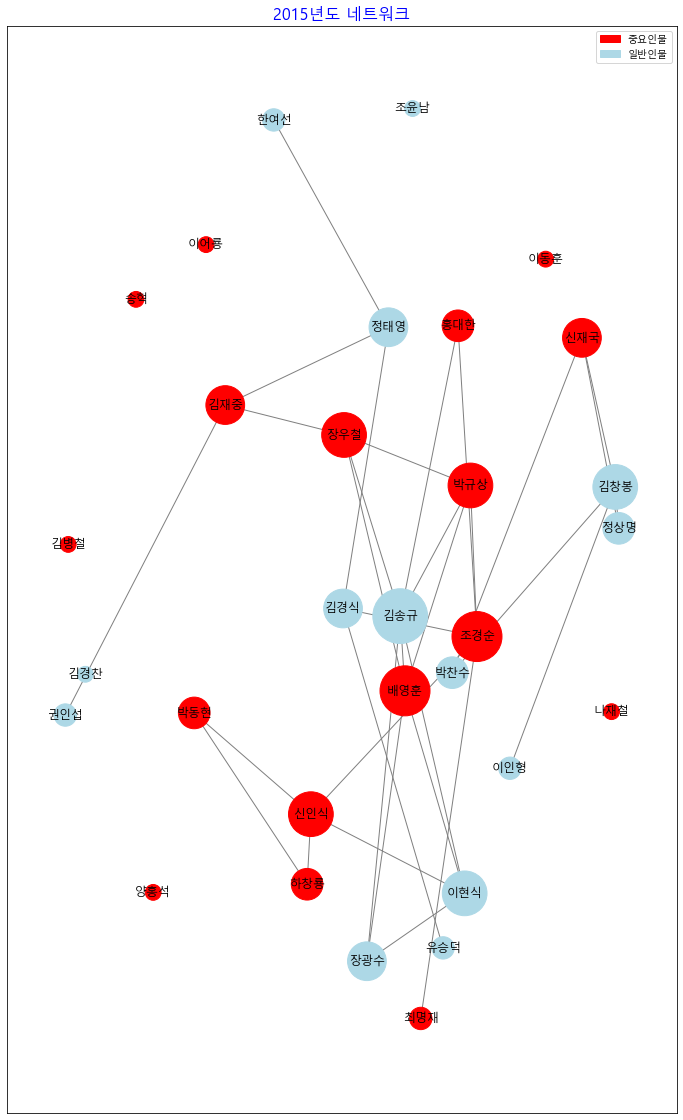

==최종 핵심 인물 점수==
조경순: 84.6770516429921
김송규: 83.93703291461283
장우철: 69.18150978430782
박규상: 67.21428414687732
배영훈: 66.0767033774243
신인식: 64.73458363669795
이현식: 59.180595176023346
김경식: 46.563314870885044
김재중: 43.82258072789012
장광수: 41.823470683409816
정태영: 40.730656088189896
홍대한: 36.198420520264506
박동현: 31.12856636978165
하창룡: 31.12856636978165
김창봉: 29.014742553049857
최명재: 23.894805979222518
권인섭: 20.31251776962867
박찬수: 17.941715525387217
정상명: 17.941715525387217
신재국: 17.71136596361831
유승덕: 16.097944641671614
한여선: 14.906298995743622
이인형: 8.711768461324604
김경찬: 0.0
김병철: 0.0
나재철: 0.0
송혁: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0
조윤남: 0.0


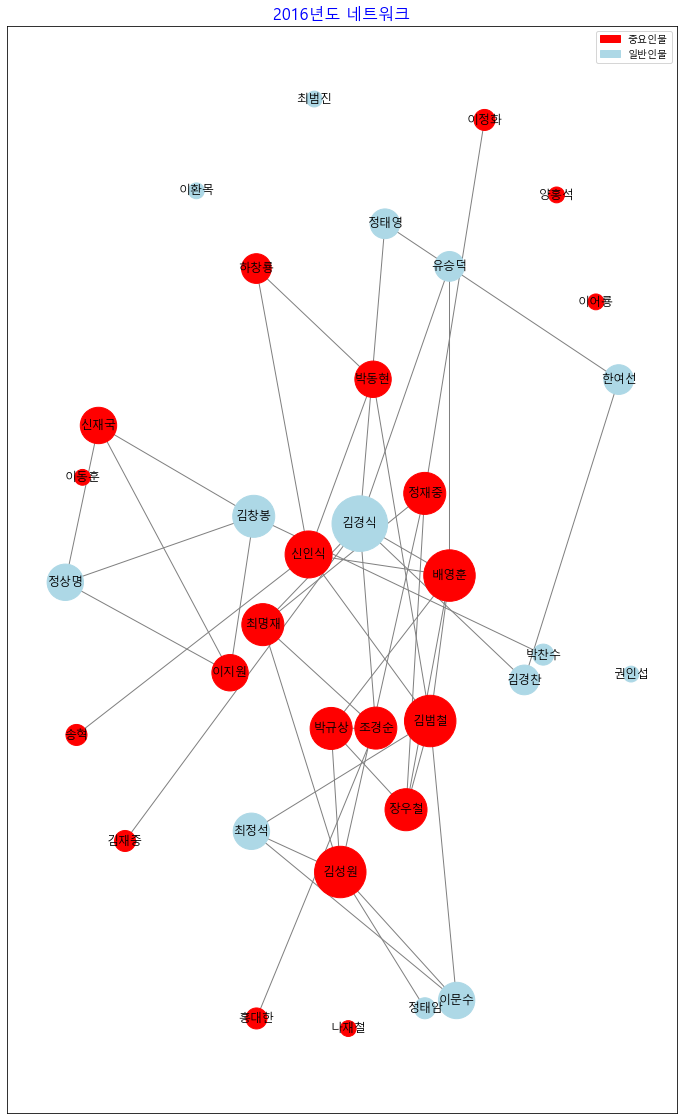

==최종 핵심 인물 점수==
김경식: 89.81750265731019
배영훈: 88.80958511784335
김범철: 77.48011752714733
신인식: 72.27315497613799
김성원: 68.93575959044533
장우철: 63.21229181742637
박규상: 62.82600624890495
최명재: 60.16701075761552
정재중: 58.87895945321213
조경순: 54.87710590150808
박동현: 42.83886430000881
이문수: 42.34508717574798
최정석: 42.34508717574798
유승덕: 33.254702591414976
하창룡: 30.32167654567031
김창봉: 27.033987402841568
김경찬: 25.209109068920938
정태영: 25.209109068920938
정상명: 22.126194749655934
정태암: 21.953494902890867
송혁: 21.215275051346907
이정화: 20.69063626569622
홍대한: 20.66129694924369
김재중: 19.286323527464745
신재국: 18.126194749655934
이지원: 18.126194749655934
한여선: 17.951465791638224
박찬수: 6.82445354606382
권인섭: 0.0
나재철: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0
이환목: 0.0
최범진: 0.0


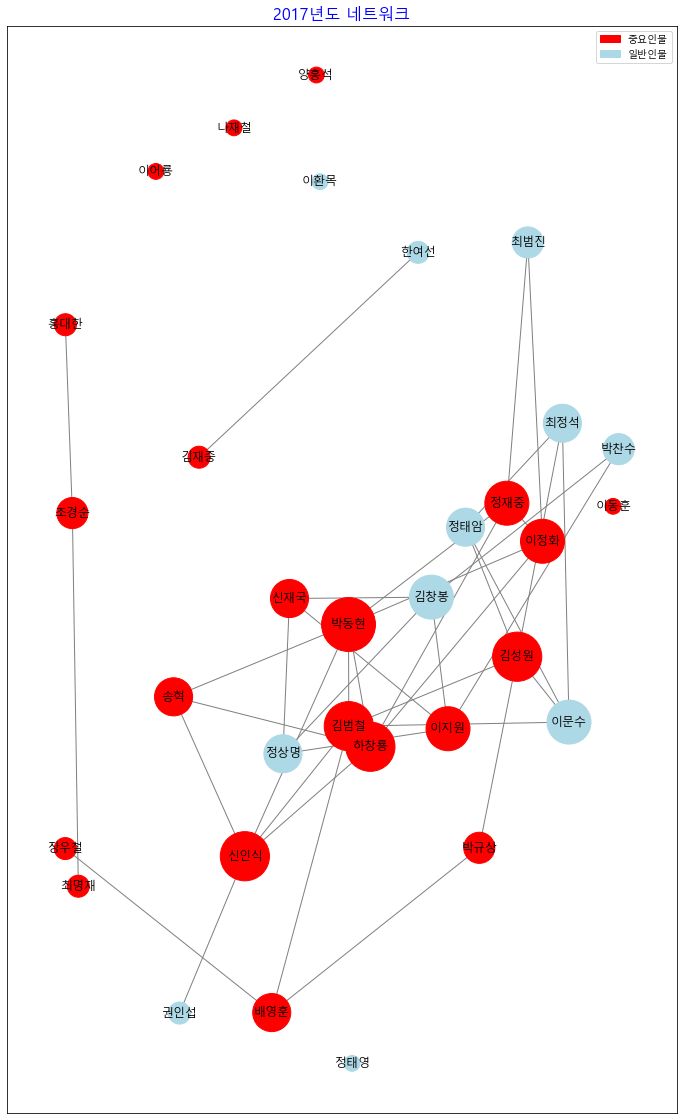

==최종 핵심 인물 점수==
박동현: 90.40926640926641
김범철: 82.38888323017575
신인식: 70.02141140449949
하창룡: 66.87993325159468
이정화: 52.63894947870592
정재중: 52.63894947870592
김성원: 52.27730433503272
송혁: 45.83357047017347
이문수: 45.13830347176364
배영훈: 44.14981802383089
최범진: 29.880273620045894
김창봉: 29.569145386428985
정태암: 29.02441937659979
최정석: 29.02441937659979
박규상: 28.6917771681227
이지원: 26.235812053095646
정상명: 24.06254641690852
권인섭: 22.13957875022147
신재국: 20.72921308357519
조경순: 18.27987987987988
장우철: 17.937391705856598
박찬수: 16.163189608672564
최명재: 9.748148148148148
홍대한: 9.748148148148148
한여선: 8.977777777777778
김재중: 5.644444444444445
나재철: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0
이환목: 0.0
정태영: 0.0


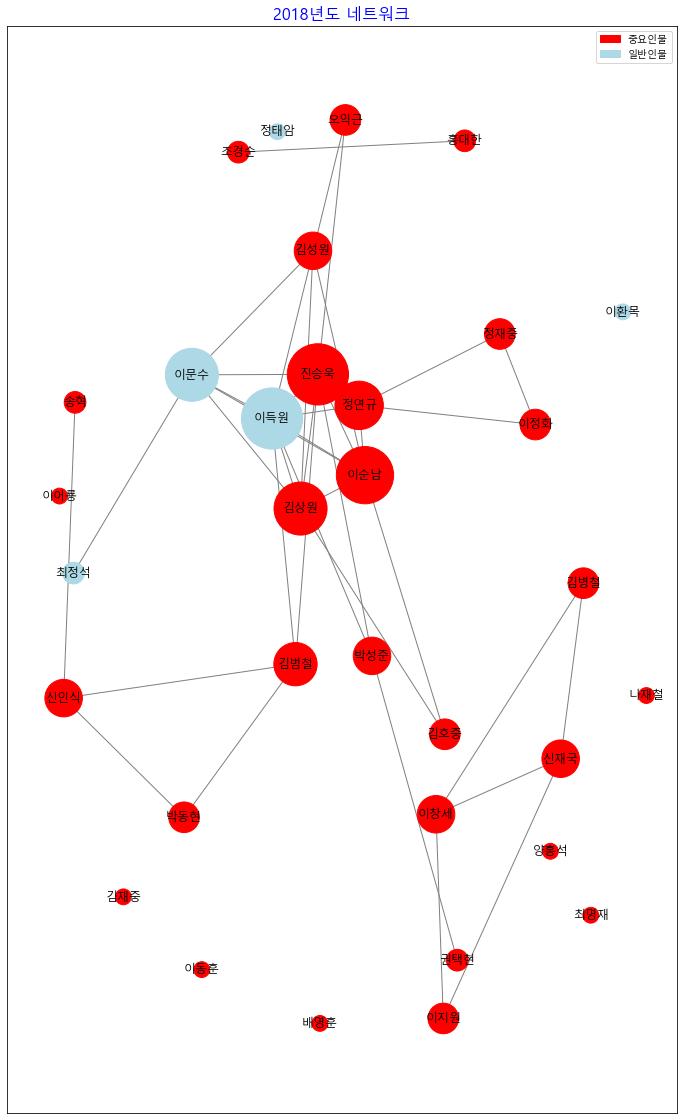

==최종 핵심 인물 점수==
이득원: 99.76190476190476
진승욱: 96.9047619047619
이순남: 76.16312351043484
이문수: 67.39577407844385
정연규: 65.60007776174737
김상원: 63.201022108810264
김범철: 61.70407738420573
박성준: 42.02725734093868
신인식: 36.63443667459638
김성원: 34.960562845747255
김호중: 28.88732003771698
오익근: 28.1428469497623
이정화: 24.24136943846022
정재중: 24.24136943846022
박동현: 23.38188236044775
신재국: 21.915296835515157
이창세: 21.915296835515157
권택현: 16.428871840990215
최정석: 16.150839804275584
김병철: 14.918622768364159
이지원: 14.918622768364159
송혁: 14.022075445973838
조경순: 7.225654971573915
홍대한: 7.225654971573915
김재중: 0.0
나재철: 0.0
배영훈: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0
이환목: 0.0
정태암: 0.0
최명재: 0.0


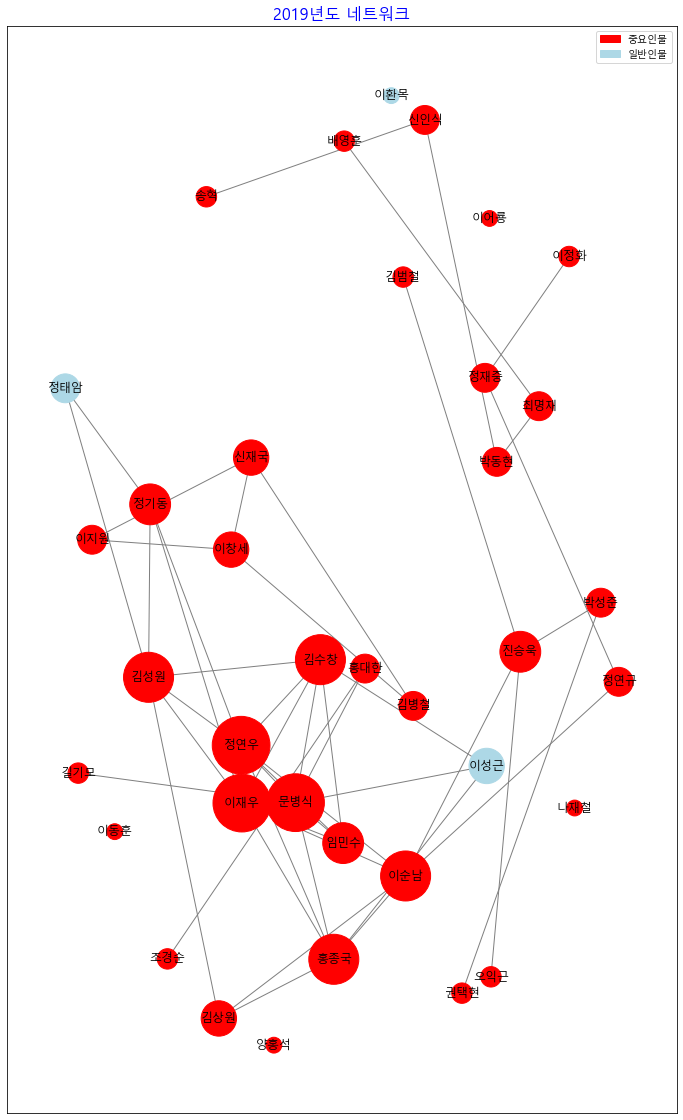

==최종 핵심 인물 점수==
이재우: 86.44485807352258
정연우: 86.44485807352258
이순남: 81.42750818314201
문병식: 80.99468476098232
홍종국: 65.16196838435732
김수창: 60.7520087780324
김성원: 58.97434034390104
진승욱: 49.74752829601811
임민수: 47.937265313028476
정기동: 43.3508762839275
김상원: 39.349951529305834
이성근: 38.28816029558251
정연규: 32.82421232335546
홍대한: 28.827162629885
정태암: 25.608837354946562
박성준: 25.36518935862373
정재중: 24.763341428903946
신재국: 20.656981969222443
이창세: 20.656981969222443
길기모: 20.113659069412638
김범철: 16.773958711730824
오익근: 16.773958711730824
박동현: 15.584088493295893
조경순: 15.207397612544108
신인식: 14.719353687369413
최명재: 14.719353687369413
권택현: 14.2521991254403
김병철: 14.184113593408101
이지원: 14.184113593408101
이정화: 13.887758294603328
배영훈: 7.975208432181098
송혁: 7.975208432181098
나재철: 0.0
양홍석: 0.0
이동훈: 0.0
이어룡: 0.0
이환목: 0.0


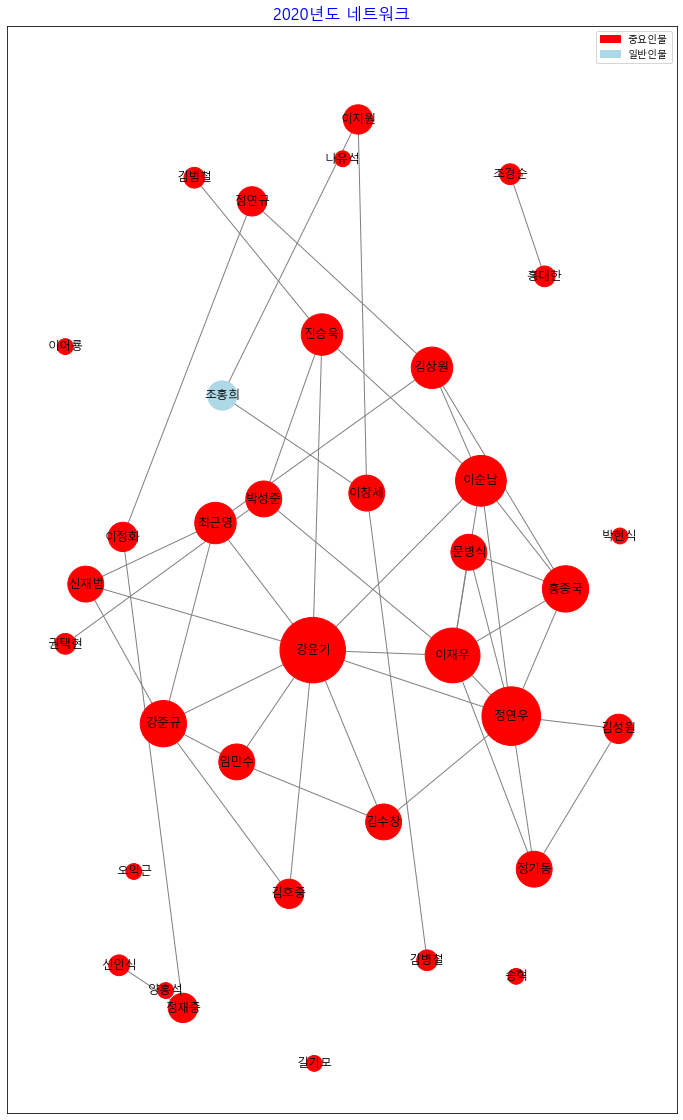

==최종 핵심 인물 점수==
강윤기: 100.0
정연우: 79.57311389471533
이재우: 73.96040630746265
이순남: 71.39463094554442
김상원: 60.61417129487179
홍종국: 56.01924902258043
진승욱: 49.64115294866294
최근영: 46.909921256157325
강준규: 46.5316761125513
정연규: 38.20671990765529
박성준: 37.23203838610626
김수창: 36.16815725540483
문병식: 36.13036696810699
신재범: 34.38846225438692
정기동: 33.87389928816109
임민수: 33.39739139919423
이정화: 29.755753505200794
김호중: 27.39951603496485
김성원: 26.161686818912706
정재중: 22.440850479628118
김범철: 17.69563140747208
이창세: 16.116269595374046
권택현: 15.65147090181277
조홍희: 12.183886284789395
신인식: 11.268830789112615
이지원: 10.183886284789395
김병철: 7.347108509529719
조경순: 5.859504132280551
홍대한: 5.859504132280551
길기모: 0.0
나유석: 0.0
박현식: 0.0
송혁: 0.0
양홍석: 0.0
오익근: 0.0
이어룡: 0.0


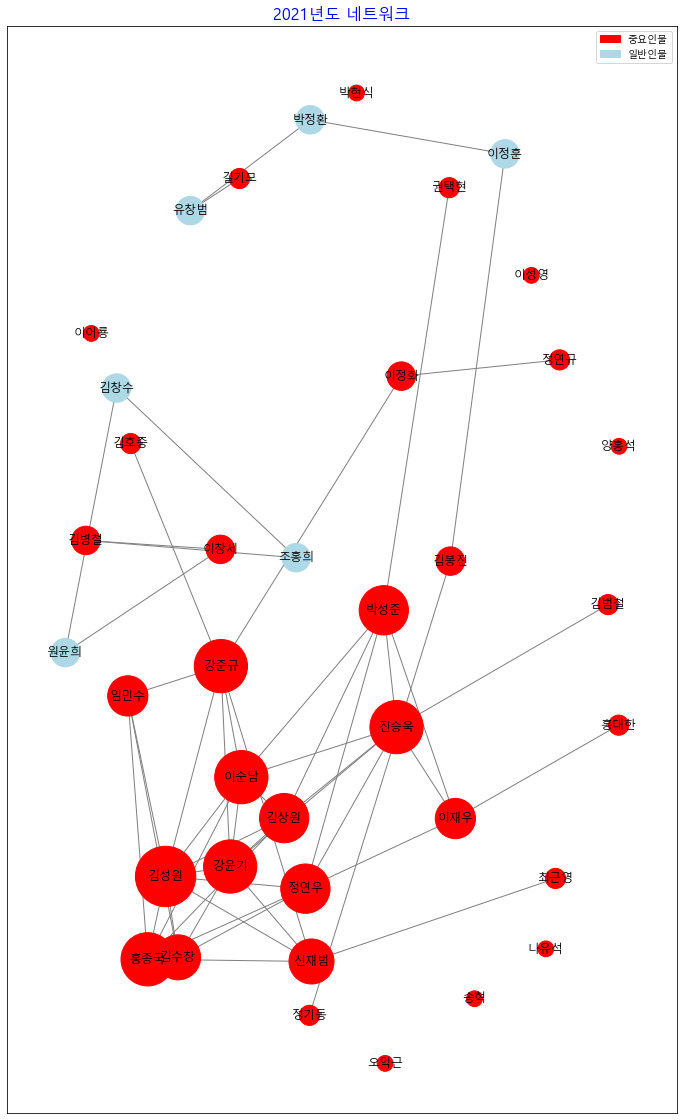

==최종 핵심 인물 점수==
김성원: 87.96410447547234
강준규: 82.20234304944881
이순남: 76.75587605512852
강윤기: 74.42938405524569
진승욱: 73.04848615232224
홍종국: 68.3014701982447
정연우: 64.85795184318212
박성준: 62.36346671433475
김상원: 61.22884240364911
신재범: 56.47353072071546
김수창: 51.45888195070326
이재우: 45.02556363481456
임민수: 43.23723566273087
이정화: 30.526811905027383
김호중: 18.74361877366076
김범철: 18.566753858363132
권택현: 17.56275536315201
최근영: 17.403337982791292
홍대한: 15.748071090808772
정연규: 14.220338652036357
이정훈: 14.015861680238947
김봉진: 12.335597811217871
유창범: 12.335597811217871
김병철: 11.92046943853892
원윤희: 11.92046943853892
이창세: 11.92046943853892
조홍희: 11.92046943853892
박정환: 11.793639458016724
김창수: 9.698247216316696
정기동: 7.491536757641286
길기모: 5.269314535419065
나유석: 0.0
박현식: 0.0
송혁: 0.0
양홍석: 0.0
오익근: 0.0
이성영: 0.0
이어룡: 0.0


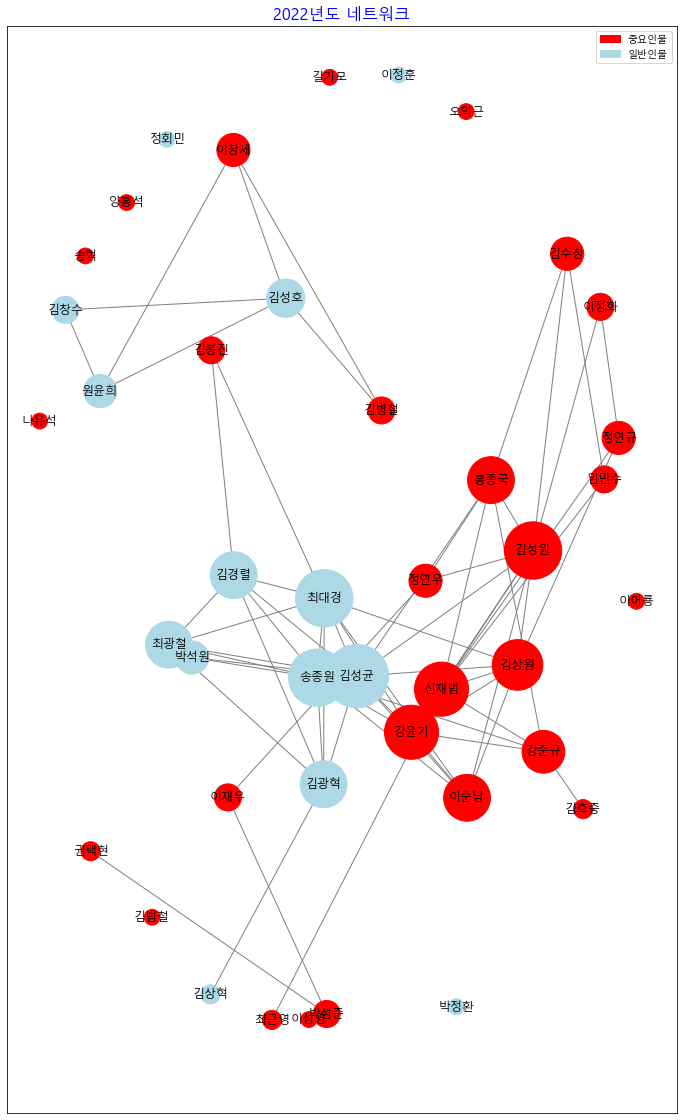

==최종 핵심 인물 점수==
김성균: 90.53611094283234
김성원: 89.06982511497776
신재범: 73.76218450462339
강윤기: 67.4686175761428
최대경: 67.04099583544682
송종원: 63.169822120134334
김상원: 62.581077940896826
홍종국: 61.835596344327335
강준규: 51.216382962946795
이순남: 50.702523889624906
정연우: 47.94345508543521
김광혁: 43.298111921958515
김경렬: 41.52207799739535
최광철: 38.290066000886846
이재우: 32.2495508739266
김수창: 31.68682545020131
정연규: 31.219989597810294
박석원: 26.277270475994296
이정화: 24.98628252804919
박성준: 23.84674045422121
임민수: 22.841826692681444
김봉진: 19.663028881083346
김성호: 18.797605167046292
최근영: 17.53031572746739
김호중: 17.414419410399887
김상혁: 14.255975863241751
원윤희: 12.894566624280564
이창세: 12.894566624280564
권택현: 11.671335778417003
김병철: 10.147032103670375
김창수: 7.647032103670373
길기모: 0.0
김범철: 0.0
나유석: 0.0
박정환: 0.0
송혁: 0.0
양홍석: 0.0
오익근: 0.0
이성영: 0.0
이어룡: 0.0
이정훈: 0.0
정회민: 0.0


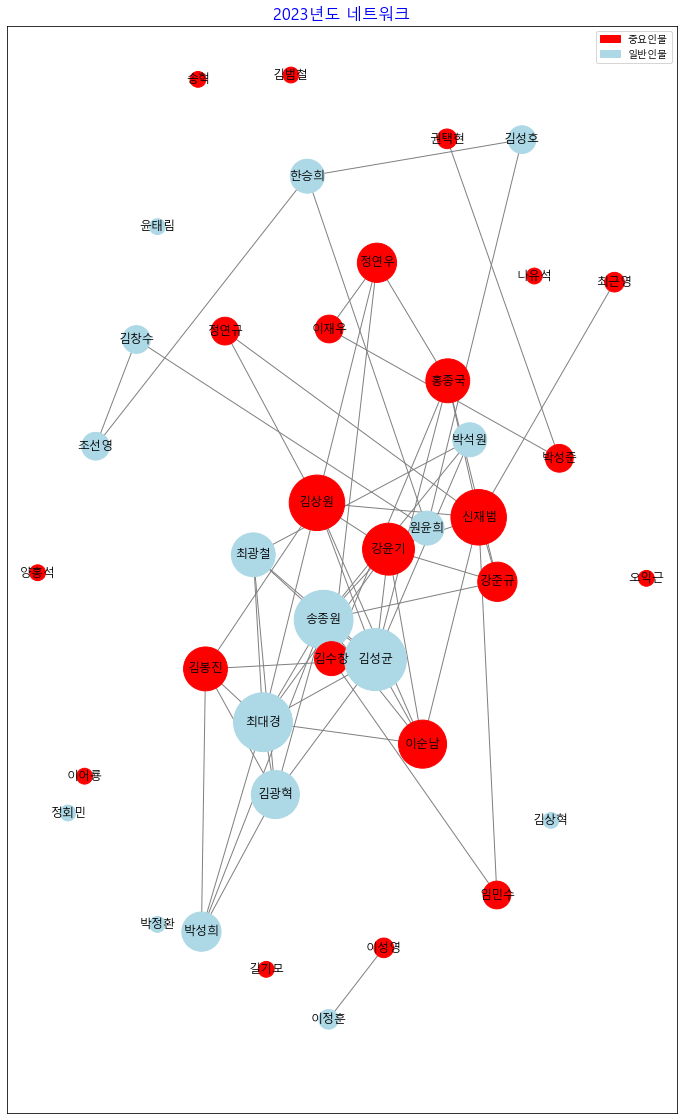

==최종 핵심 인물 점수==
김상원: 85.78492086433639
김성균: 83.42987471066104
신재범: 76.27030766195199
최대경: 70.39905434723795
송종원: 64.595021514511
강윤기: 60.39002829543693
정연우: 57.362772202930636
홍종국: 54.06019113912858
이순남: 53.82649083120017
김광혁: 42.53404623854462
김봉진: 41.88267527093864
강준규: 41.15243967384427
최광철: 35.69131507095952
이재우: 34.50969379218823
박성희: 32.98154890109579
김수창: 30.647943403800078
정연규: 26.938652684797866
박석원: 26.676049457192935
박성준: 25.206298204562316
임민수: 24.11214307160236
최근영: 17.549959606287192
권택현: 11.98726658261763
원윤희: 11.876309185730644
한승희: 11.876309185730644
김창수: 8.643578665901112
조선영: 8.643578665901112
김성호: 8.474682724912636
이정훈: 6.178004535259972
이성영: 3.6780045352599724
길기모: 0.0
김범철: 0.0
김상혁: 0.0
나유석: 0.0
박정환: 0.0
송혁: 0.0
양홍석: 0.0
오익근: 0.0
윤태림: 0.0
이어룡: 0.0
정회민: 0.0


In [169]:
print_network(matrixs)